In [17]:
import pandas as pd
import numpy as np
from selenium import webdriver
import main
import visualizer
from mplsoccer.pitch import Pitch
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt

options = webdriver.ChromeOptions()    
driver = webdriver.Remote(
command_executor='ylenium_driver_1:4444/wd/hub',
options=options,
)

# main_url = 'https://www.whoscored.com'

url = "https://www.whoscored.com/Matches/1491975/Live/Spain-LaLiga-2020-2021-Barcelona-Villarreal"

match_data = main.getMatchData(driver, url)

matches_df = main.createMatchesDF(match_data)

events_df = main.createEventsDF(match_data)

matchId = match_data['matchId']

home_data = matches_df['home'][matchId]
away_data = matches_df['away'][matchId]

team = 'Barcelona'
teamId = 65
# opponent = ['Villarreal', 'Celta-Vigo', 'Sevilla', 'Getafe', 'Real-Madrid', 'Alaves', 'Betis', 'Atletico',
#             'Osasuna', 'Cadiz', 'Levante', 'Real-Sociedad', 'Valencia', 'Valladolid', 'Eibar']
opponent = 'Osasuna'
venue = 'home'





In [18]:
team_players_dict = {}
for player in matches_df[venue][matchId]['players']:
    team_players_dict[player['playerId']] = player['name']

match_events_df = events_df[events_df['matchId']==matchId].reset_index(drop=True)

passes_df = match_events_df.loc[[
        row['displayName']=='Pass' for row in list(match_events_df['type'])
]].reset_index(drop=True)

passes_df = passes_df[passes_df['teamId']==teamId].reset_index().drop('index', axis=1)

passes_df = passes_df.loc[[
    row['displayName']=='Successful' for row in list(
        passes_df['outcomeType']
    )
]].reset_index(drop=True)

passes_df.insert(
    27, 
    column='playerName', 
    value=[
        team_players_dict[i] for i in list(passes_df['playerId'])
    ]
)

passes_df.insert(
    28, 
    column='passRecipientId', 
    value=passes_df['playerId'].shift(-1)
)

passes_df.insert(
    29,
    column='passRecipientName',
    value=passes_df['playerName'].shift(-1)
)

passes_df.dropna(subset=['passRecipientName'], inplace=True)

match_player_df = pd.DataFrame()
player_names = []
player_ids = []
player_pos = []
player_kit_number = []

for player in matches_df[venue][matchId]['players']:
    player_names.append(player['name'])
    player_ids.append(player['playerId'])
    player_pos.append(player['position'])
    player_kit_number.append(player['shirtNo'])
    
match_player_df['playerId'] = player_ids
match_player_df['playerName']=player_names
match_player_df['playerPos']=player_pos
match_player_df['playerKitNumber']=player_kit_number

passes_df = passes_df.merge(
    match_player_df,
    on=['playerId', 'playerName'],
    how='left',
    validate='m:1'
)
passes_df = passes_df.merge(
    match_player_df.rename({
      'playerId': 'passRecipientId', 'playerName': 'passRecipientName'  
    }, axis='columns'),
    on=['passRecipientId', 'passRecipientName'],
    how='left',
    validate='m:1',
    suffixes=['', '_Receipt']
)

passes_df = passes_df[passes_df['playerPos'] != 'Sub']
passes_formation = passes_df[[
        'id', 'playerKitNumber', 'playerKitNumber_Receipt']].copy()

location_formation = passes_df[['playerKitNumber', 'x', 'y']]

average_locs_and_count = location_formation.groupby('playerKitNumber').agg(
    {'x':['mean', 'median'], 'y':['mean', 'median', 'count']}
)
# average_locs_and_count = location_formation.groupby(
#         'playerKitNumber').agg({'x': ['mean'], 'y': ['mean', 'count']})

average_locs_and_count.columns = ['x_mean', 'x_median', 'y_mean', 'y_median', 'count']

passes_formation['kitNo_max'] = passes_formation[[
    'playerKitNumber', 'playerKitNumber_Receipt'
]].max(axis='columns')

passes_formation['kitNo_min'] = passes_formation[[
        'playerKitNumber', 'playerKitNumber_Receipt'
]].min(axis='columns')

passes_between = passes_formation.groupby(
    ['kitNo_max', 'kitNo_min']
)['id'].count().reset_index()

passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

passes_between = passes_between.merge(
    average_locs_and_count,
    left_on='kitNo_min',
    right_index=True)

passes_between = passes_between.merge(
    average_locs_and_count,
    left_on='kitNo_max',
    right_index=True,
    suffixes=['','_end']
)

max_lw = 10
max_marker_size = 1000
max_line_width = max_lw
passes_between['width'] = passes_between['pass_count'] / \
    passes_between['pass_count'].max() * max_line_width

average_locs_and_count['marker_size'] = (
    average_locs_and_count['count'] / average_locs_and_count['count'].max() * max_marker_size
)

min_transparency = 0.3
color = np.array(to_rgba('white'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between['pass_count'] / passes_between['pass_count'].max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:,3] = c_transparency

Text(72, 77, 'Source: Fbref.com | Whoscored.com')

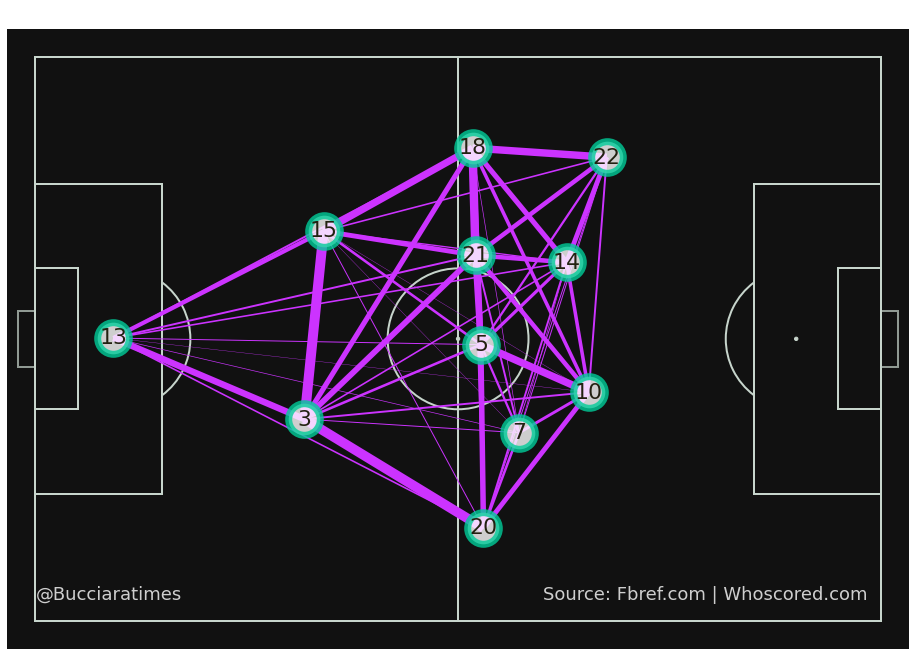

In [19]:
pitch_color = '#111111'
pitch = Pitch(
    pitch_type='statsbomb',
    orientation='horizontal',
    pitch_color=pitch_color,
    line_color='#c7d5cc',
    figsize=(16,9),
    goal_type='box',
    constrained_layout=True,
    tight_layout=False
)
fix, ax = pitch.draw()

pitch.lines(
    passes_between['x_mean'] / 100 * 120,
    80 - passes_between['y_mean'] / 100 * 80,
    passes_between['x_mean_end'] / 100 * 120,
    80 - passes_between['y_mean_end'] / 100 * 80,
    lw=passes_between['width'],
    color='#CC33FF',
    zorder=1,
    ax=ax
)
pitch.scatter(
        average_locs_and_count['x_mean'] /
        100 * 120,
        80 - average_locs_and_count['y_mean'] /
        100 * 80,
        s=1000,
        alpha=0.8,
        c='#FFFFFF',
        edgecolors='#00CC99',
        linewidth=7,
#         marker='football',
        ax=ax)

for index, row in average_locs_and_count.iterrows():
        pitch.annotate(index,
                       xy=(row['x_mean'] / 100 * 120, 80 - row['y_mean'] / 100 * 80),
                       c='#222111',
                       va='center',
                       ha='center',
                       size=22,
#                        weight='bold',
                       ax=ax)

# pitch.lines(
#     passes_between['x_median'] / 100 * 120,
#     80 - passes_between['y_median'] / 100 * 80,
#     passes_between['x_median_end'] / 100 * 120,
#     80 - passes_between['y_median_end'] / 100 * 80,
#     lw=passes_between['width'],
#     color='#990099',
#     zorder=1,
#     ax=ax
# )
# pitch.scatter(
#     average_locs_and_count['x_median'] /
#     100 *
#     120,
#     80 -
#     average_locs_and_count['y_median'] /
#     100 *
#     80,
#     s=1000,
#     alpha=0.8,
#     color='#000000',
#     edgecolors='#FF0033',
#     linewidth=5,
#     ax=ax)
# for index, row in average_locs_and_count.iterrows():
#     print(index)
#     pitch.annotate(index,
#                    xy=(row['x_median'] / 100 * 120,
#                        80 - row['y_median'] / 100 * 80),
#                    c='white',
#                    va='baseline',
#                    ha='left',
#                    size=33,
#                                           weight='bold',
#                    ax=ax)

plt.text(29,-5, f"Barca'positioning based on Passes [vs {opponent[1]}]", color='white',alpha=1, fontsize=20) 
plt.text(0,77, '@Bucciaratimes', color='white',alpha=0.8, fontsize=18) 
plt.text(72,77, 'Source: Fbref.com | Whoscored.com',color='white',alpha=0.8, fontsize=18)


In [ ]:
df = pd.DataFrame({
    'class':['a','a','a','b','b','c'],
    'sex':['m','w','m','m','w','w'], 
    'score':[0,20,10,1,3,21]})
df
df.groupby(['class', 'sex']).count()

In [ ]:
row_index = 0
col_index = 0

pitch_color = '#111111'
pitch = Pitch(
    pitch_type='statsbomb',
    orientation='horizontal',
    pitch_color=pitch_color,
    line_color='#c7d5cc',
    figsize=(16,11),
    goal_type='box',
    constrained_layout=True,
    tight_layout=False,
    layout=(2, 2)
)
fig, axes = pitch.draw()

match_urls = [
    "https://www.whoscored.com/Matches/1491975/Live/Spain-LaLiga-2020-2021-Barcelona-Villarreal",
    "https://www.whoscored.com/Matches/1491984/Live/Spain-LaLiga-2020-2021-Celta-Vigo-Barcelona",
    "https://www.whoscored.com/Matches/1491995/Live/Spain-LaLiga-2020-2021-Barcelona-Sevilla",
    "https://www.whoscored.com/Matches/1492021/Live/Spain-LaLiga-2020-2021-Getafe-Barcelona",
    "https://www.whoscored.com/Matches/1492033/Live/Spain-LaLiga-2020-2021-Barcelona-Real-Madrid",
    "https://www.whoscored.com/Matches/1492047/Live/Spain-LaLiga-2020-2021-Deportivo-Alaves-Barcelona",
    "https://www.whoscored.com/Matches/1492327/Live/Spain-LaLiga-2020-2021-Barcelona-Real-Betis",
    "https://www.whoscored.com/Matches/1492008/Live/Spain-LaLiga-2020-2021-Atletico-Madrid-Barcelona",
    "https://www.whoscored.com/Matches/1492024/Live/Spain-LaLiga-2020-2021-Barcelona-Osasuna",
    "https://www.whoscored.com/Matches/1492054/Live/Spain-LaLiga-2020-2021-Cadiz-Barcelona",
    "https://www.whoscored.com/Matches/1492065/Live/Spain-LaLiga-2020-2021-Barcelona-Levante",
    "https://www.whoscored.com/Matches/1492121/Live/Spain-LaLiga-2020-2021-Barcelona-Real-Sociedad",
    "https://www.whoscored.com/Matches/1492089/Live/Spain-LaLiga-2020-2021-Barcelona-Valencia",
    "https://www.whoscored.com/Matches/1492060/Live/Spain-LaLiga-2020-2021-Real-Valladolid-Barcelona",
    "https://www.whoscored.com/Matches/1492070/Live/Spain-LaLiga-2020-2021-Barcelona-Eibar"
]
opponents = [
    'Villarreal', 'Celta-Vigo', 'Sevilla', 'Getafe', 'Real-Madrid', 'Alaves', 'Betis', 'Atletico',
    'Osasuna', 'Cadiz', 'Levante', 'Real-Sociedad', 'Valencia', 'Valladolid', 'Eibar'
]

teamId = 65

options = webdriver.ChromeOptions()    
driver = webdriver.Remote(
    command_executor='ylenium_driver_1:4444/wd/hub',
    options=options,
)


for url in match_urls:
    
    match_data = main.getMatchData(driver, url)

    matches_df = main.createMatchesDF(match_data)

    events_df = main.createEventsDF(match_data)

    matchId = match_data['matchId']

    home_data = matches_df['home'][matchId]
    away_data = matches_df['away'][matchId]

    if matches_df['venueName'].bool == 'Camp Nou':
        venue = 'home'
    else:
        venue = 'away'

    team_players_dict = {}
    for player in matches_df[venue][matchId]['players']:
        team_players_dict[player['playerId']] = player['name']

    match_events_df = events_df[events_df['matchId']==matchId].reset_index(drop=True)

    passes_df = match_events_df.loc[[
            row['displayName']=='Pass' for row in list(match_events_df['type'])
    ]].reset_index(drop=True)

    passes_df = passes_df[passes_df['teamId']==teamId].reset_index().drop('index', axis=1)

    passes_df = passes_df.loc[[
        row['displayName']=='Successful' for row in list(
            passes_df['outcomeType']
        )
    ]].reset_index(drop=True)


    passes_df.insert(
        27, 
        column='playerName', 
        value=[
            team_players_dict[i] for i in list(passes_df['playerId'])
        ]
    )

    passes_df.insert(
        28, 
        column='passRecipientId', 
        value=passes_df['playerId'].shift(-1)
    )

    passes_df.insert(
        29,
        column='passRecipientName',
        value=passes_df['playerName'].shift(-1)
    )

    passes_df.dropna(subset=['passRecipientName'], inplace=True)

    match_player_df = pd.DataFrame()
    player_names = []
    player_ids = []
    player_pos = []
    player_kit_number = []

    for player in matches_df[venue][matchId]['players']:
        player_names.append(player['name'])
        player_ids.append(player['playerId'])
        player_pos.append(player['position'])
        player_kit_number.append(player['shirtNo'])

    match_player_df['playerId'] = player_ids
    match_player_df['playerName']=player_names
    match_player_df['playerPos']=player_pos
    match_player_df['playerKitNumber']=player_kit_number

    passes_df = passes_df.merge(
        match_player_df,
        on=['playerId', 'playerName'],
        how='left',
        validate='m:1'
    )
    passes_df = passes_df.merge(
        match_player_df.rename({
          'playerId': 'passRecipientId', 'playerName': 'passRecipientName'  
        }, axis='columns'),
        on=['passRecipientId', 'passRecipientName'],
        how='left',
        validate='m:1',
        suffixes=['', '_Receipt']
    )

    passes_df = passes_df[passes_df['playerPos'] != 'Sub']
    passes_formation = passes_df[[
            'id', 'playerKitNumber', 'playerKitNumber_Receipt']].copy()

    location_formation = passes_df[['playerKitNumber', 'x', 'y']]

    average_locs_and_count = location_formation.groupby('playerKitNumber').agg(
        {'x':['mean', 'median'], 'y':['mean', 'median', 'count']}
    )
    # average_locs_and_count = location_formation.groupby(
    #         'playerKitNumber').agg({'x': ['mean'], 'y': ['mean', 'count']})

    average_locs_and_count.columns = ['x_mean', 'x_median', 'y_mean', 'y_median', 'count']

    passes_formation['kitNo_max'] = passes_formation[[
        'playerKitNumber', 'playerKitNumber_Receipt'
    ]].max(axis='columns')

    passes_formation['kitNo_min'] = passes_formation[[
            'playerKitNumber', 'playerKitNumber_Receipt'
    ]].min(axis='columns')

    passes_between = passes_formation.groupby(
        ['kitNo_max', 'kitNo_min']
    )['id'].count().reset_index()

    passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    passes_between = passes_between.merge(
        average_locs_and_count,
        left_on='kitNo_min',
        right_index=True)

    passes_between = passes_between.merge(
        average_locs_and_count,
        left_on='kitNo_max',
        right_index=True,
        suffixes=['','_end']
    )

    max_lw = 10
    max_marker_size = 1000
    max_line_width = max_lw
    passes_between['width'] = passes_between['pass_count'] / \
        passes_between['pass_count'].max() * max_line_width

    average_locs_and_count['marker_size'] = (
        average_locs_and_count['count'] / average_locs_and_count['count'].max() * max_marker_size
    )

    min_transparency = 0.3
    color = np.array(to_rgba('white'))
    color = np.tile(color, (len(passes_between), 1))
    c_transparency = passes_between['pass_count'] / passes_between['pass_count'].max()
    c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
    color[:,3] = c_transparency



    pitch.lines(
        passes_between['x_mean'] / 100 * 120,
        80 - passes_between['y_mean'] / 100 * 80,
        passes_between['x_mean_end'] / 100 * 120,
        80 - passes_between['y_mean_end'] / 100 * 80,
        lw=passes_between['width'],
        color='#CC33FF',
        zorder=1,
        ax=axes[row_index,col_index]
    )
    pitch.scatter(
        average_locs_and_count['x_mean'] /
        100 * 120,
        80 - average_locs_and_count['y_mean'] /
        100 * 80,
        s=1000,
        alpha=0.8,
        c='#FFFFFF',
        edgecolors='#00CC99',
        linewidth=7,
        ax=axes[row_index,col_index]
    )

#     for index, row in average_locs_and_count.iterrows():
#         pitch.annotate(index,
#                        xy=(row['x_mean'] / 100 * 120, 80 - row['y_mean'] / 100 * 80),
#                        c='#222111',
#                        va='center',
#                        ha='center',
#                        size=22,
#                        ax=axes[row,col]
#                       )
    
    col_index += 1
    if col_index == 2:
        col_index = 0
        row_index += 1
    elif row_index == 2:
        break